### anomaly_detection_lesson_29Apr19_timeseries_anomalies

#### Anomalies in the amount of data consumed over time

In [37]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

In [2]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()  

In [3]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [4]:
### Alter feature 'timestamp' multiple times:
df.timestamp = df.timestamp.str.replace('[', '')
df.timestamp = df.timestamp.str.replace(']', '')
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')
# df = df.tz_localize('utc').tz_convert('America/Chicago')

In [5]:
df.request_method = df.request_method.str.replace('"', '')
df.request_agent = df.request_agent.str.replace('"', '')
df.destination = df.destination.str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [6]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [7]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [ ]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

Resampled into 30 min chunks

In [9]:
df_ts_size = df['size_mb'].resample('30T').median()

In [10]:
df_ts_size.head()

timestamp
2019-04-16 19:30:00    0.486491
2019-04-16 20:00:00    0.486506
2019-04-16 20:30:00    0.486503
2019-04-16 21:00:00    0.486506
2019-04-16 21:30:00    0.486509
Freq: 30T, Name: size_mb, dtype: float64

In [11]:
df_ts_size

timestamp
2019-04-16 19:30:00    0.486491
2019-04-16 20:00:00    0.486506
2019-04-16 20:30:00    0.486503
2019-04-16 21:00:00    0.486506
2019-04-16 21:30:00    0.486509
2019-04-16 22:00:00    0.486512
2019-04-16 22:30:00    0.486687
2019-04-16 23:00:00         NaN
2019-04-16 23:30:00    0.000097
2019-04-17 00:00:00         NaN
2019-04-17 00:30:00    0.002550
2019-04-17 01:00:00    0.000332
2019-04-17 01:30:00    0.486511
2019-04-17 02:00:00    0.486511
2019-04-17 02:30:00    0.003489
2019-04-17 03:00:00    0.482626
2019-04-17 03:30:00    0.486662
2019-04-17 04:00:00    0.001266
2019-04-17 04:30:00    0.003489
2019-04-17 05:00:00    0.486492
2019-04-17 05:30:00    0.003396
2019-04-17 06:00:00    0.003396
2019-04-17 06:30:00         NaN
2019-04-17 07:00:00         NaN
2019-04-17 07:30:00         NaN
2019-04-17 08:00:00         NaN
2019-04-17 08:30:00         NaN
2019-04-17 09:00:00         NaN
2019-04-17 09:30:00         NaN
2019-04-17 10:00:00    0.001266
                         ...  

#### Below fills in any missing events/datetimes where no activity occured

In [12]:
idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

#### this fills in those no-activity datetimes with zero

In [13]:
df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

In [14]:
df_ts_size

2019-04-16 19:30:00    0.486491
2019-04-16 20:00:00    0.486506
2019-04-16 20:30:00    0.486503
2019-04-16 21:00:00    0.486506
2019-04-16 21:30:00    0.486509
2019-04-16 22:00:00    0.486512
2019-04-16 22:30:00    0.486687
2019-04-16 23:00:00    0.000000
2019-04-16 23:30:00    0.000097
2019-04-17 00:00:00    0.000000
2019-04-17 00:30:00    0.002550
2019-04-17 01:00:00    0.000332
2019-04-17 01:30:00    0.486511
2019-04-17 02:00:00    0.486511
2019-04-17 02:30:00    0.003489
2019-04-17 03:00:00    0.482626
2019-04-17 03:30:00    0.486662
2019-04-17 04:00:00    0.001266
2019-04-17 04:30:00    0.003489
2019-04-17 05:00:00    0.486492
2019-04-17 05:30:00    0.003396
2019-04-17 06:00:00    0.003396
2019-04-17 06:30:00    0.000000
2019-04-17 07:00:00    0.000000
2019-04-17 07:30:00    0.000000
2019-04-17 08:00:00    0.000000
2019-04-17 08:30:00    0.000000
2019-04-17 09:00:00    0.000000
2019-04-17 09:30:00    0.000000
2019-04-17 10:00:00    0.001266
                         ...   
2019-04-

### This is preparing the data so we can look at the avg, SMA, EMA and %B.

In [15]:
start_date_train = df_ts_size.head(1).index[0]

In [16]:
end_date_train = '2019-04-17 23:30:00'

In [17]:
start_date_test = '2019-04-18 00:00:00'

In [18]:
train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

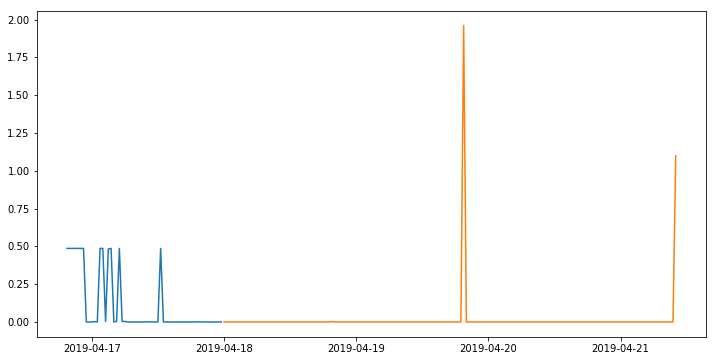

In [19]:
plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(test)
plt.show()

#### Think of this as:  Training is existing data, while test is new data coming in

In [25]:
short_rolling = train.rolling(window=12).mean()
short_rolling.head(20)
# window means give me 12 increments of how I have set this... in this case 30 min chunks, or "6 hours"

2019-04-16 19:30:00         NaN
2019-04-16 20:00:00         NaN
2019-04-16 20:30:00         NaN
2019-04-16 21:00:00         NaN
2019-04-16 21:30:00         NaN
2019-04-16 22:00:00         NaN
2019-04-16 22:30:00         NaN
2019-04-16 23:00:00         NaN
2019-04-16 23:30:00         NaN
2019-04-17 00:00:00         NaN
2019-04-17 00:30:00         NaN
2019-04-17 01:00:00    0.284058
2019-04-17 01:30:00    0.284059
2019-04-17 02:00:00    0.284060
2019-04-17 02:30:00    0.243809
2019-04-17 03:00:00    0.243485
2019-04-17 03:30:00    0.243498
2019-04-17 04:00:00    0.203061
2019-04-17 04:30:00    0.162795
2019-04-17 05:00:00    0.203336
Freq: 30T, Name: size_mb, dtype: float64

In [22]:
long_rolling = train.rolling(window=24).mean()

Text(0, 0.5, 'Size (MB)')

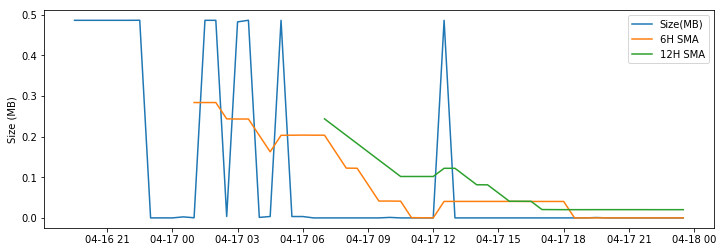

In [26]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(train.index, train, label='Size(MB)')
ax.plot(short_rolling.index, short_rolling, label='6H SMA')
ax.plot(long_rolling.index, long_rolling, label='12H SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

In [ ]:
# now change the SMA (simple moving avg) to EMA (exponential moving avg), here using ewm (expon. weighted mean)

In [31]:
# span means, like window, "number of time periods"
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short[0:40]

2019-04-16 19:30:00    0.486491
2019-04-16 20:00:00    0.486494
2019-04-16 20:30:00    0.486495
2019-04-16 21:00:00    0.486497
2019-04-16 21:30:00    0.486499
2019-04-16 22:00:00    0.486501
2019-04-16 22:30:00    0.486529
2019-04-16 23:00:00    0.411679
2019-04-16 23:30:00    0.348358
2019-04-17 00:00:00    0.294765
2019-04-17 00:30:00    0.249809
2019-04-17 01:00:00    0.211428
2019-04-17 01:30:00    0.253748
2019-04-17 02:00:00    0.289558
2019-04-17 02:30:00    0.245547
2019-04-17 03:00:00    0.282021
2019-04-17 03:30:00    0.313504
2019-04-17 04:00:00    0.265468
2019-04-17 04:30:00    0.225163
2019-04-17 05:00:00    0.265368
2019-04-17 05:30:00    0.225064
2019-04-17 06:00:00    0.190962
2019-04-17 06:30:00    0.161583
2019-04-17 07:00:00    0.136724
2019-04-17 07:30:00    0.115690
2019-04-17 08:00:00    0.097891
2019-04-17 08:30:00    0.082831
2019-04-17 09:00:00    0.070088
2019-04-17 09:30:00    0.059305
2019-04-17 10:00:00    0.050376
2019-04-17 10:30:00    0.042626
2019-04-

In [32]:
ema_long = train.ewm(span=24, adjust=False).mean()
ema_long[0:30]

2019-04-16 19:30:00    0.486491
2019-04-16 20:00:00    0.486492
2019-04-16 20:30:00    0.486493
2019-04-16 21:00:00    0.486494
2019-04-16 21:30:00    0.486495
2019-04-16 22:00:00    0.486497
2019-04-16 22:30:00    0.486512
2019-04-16 23:00:00    0.447591
2019-04-16 23:30:00    0.411792
2019-04-17 00:00:00    0.378848
2019-04-17 00:30:00    0.348744
2019-04-17 01:00:00    0.320871
2019-04-17 01:30:00    0.334123
2019-04-17 02:00:00    0.346314
2019-04-17 02:30:00    0.318888
2019-04-17 03:00:00    0.331987
2019-04-17 03:30:00    0.344361
2019-04-17 04:00:00    0.316913
2019-04-17 04:30:00    0.291839
2019-04-17 05:00:00    0.307412
2019-04-17 05:30:00    0.283090
2019-04-17 06:00:00    0.260715
2019-04-17 06:30:00    0.239858
2019-04-17 07:00:00    0.220669
2019-04-17 07:30:00    0.203015
2019-04-17 08:00:00    0.186774
2019-04-17 08:30:00    0.171832
2019-04-17 09:00:00    0.158086
2019-04-17 09:30:00    0.145439
2019-04-17 10:00:00    0.133905
Freq: 30T, Name: size_mb, dtype: float64

Text(0, 0.5, 'Size (MB)')

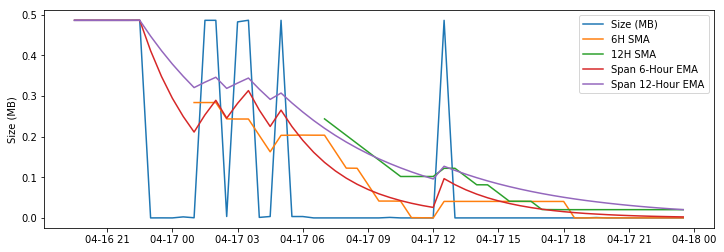

In [42]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(train.index, train, label='Size (MB)')
ax.plot(short_rolling.index, short_rolling, label='6H SMA')
ax.plot(long_rolling.index, long_rolling, label='12H SMA')
ax.plot(long_rolling.index, ema_short, label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, ema_long, label = 'Span 12-Hour EMA')
ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

### Forecast using the EMA

In [44]:
yhat = pd.DataFrame(dict(actual=test))

In [45]:
# periods = 24, ie the "ema_long" set
yhat['moving_avg_forecast'] = ema_long.iloc[-1]

In [46]:
yhat['moving_avg_forecast'].head()

2019-04-18 00:00:00    0.020349
2019-04-18 00:30:00    0.020349
2019-04-18 01:00:00    0.020349
2019-04-18 01:30:00    0.020349
2019-04-18 02:00:00    0.020349
Freq: 30T, Name: moving_avg_forecast, dtype: float64

#### Compute the '%b' for each record

In [47]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)
# this is the absolute error

In [50]:
yhat.head()

,actual,moving_avg_forecast,error
2019-04-18 00:00:00,0.0,0.020349,0.020349
2019-04-18 00:30:00,0.0,0.020349,0.020349
2019-04-18 01:00:00,0.0,0.020349,0.020349
2019-04-18 01:30:00,0.0,0.020349,0.020349
2019-04-18 02:00:00,0.0,0.020349,0.020349


In [51]:
# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

q3 = yhat.error.describe().loc['75%']
q3

0.020349393893732613

In [52]:
q1 = yhat.error.describe().loc['25%']
q1
# using the 75% and 25% percentiles cutoffs

0.020349393893732613

In [53]:
# now calculate the upper band ('ub') and lower band ('lb')
# adding .1 to the IQR so the we don't end up with a denominator of 0.

# here the "3" is a cutoff weight, to be less sensitive to the anomalies.
# to cast a wider number, decrease the cutoff weight
# this is like changing the range for the standard deviation number

ub = q3 + 3*(q3-q1+.1)
lb = q1 - 3*(q3-q1+.1)

In [54]:
ub

0.3203493938937327

In [55]:
lb

-0.2796506061062674

In [56]:
yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)
# to the right of the equal sign is the formula for the %B number.

In [60]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-04-19 19:30:00,1.961066,0.020349,1.940717,3.734528
2019-04-21 10:00:00,1.099591,0.020349,1.079242,2.298736


#### Extract the anomalies

In [ ]:
yhat[yhat.pct_b > 1]

#### Plot

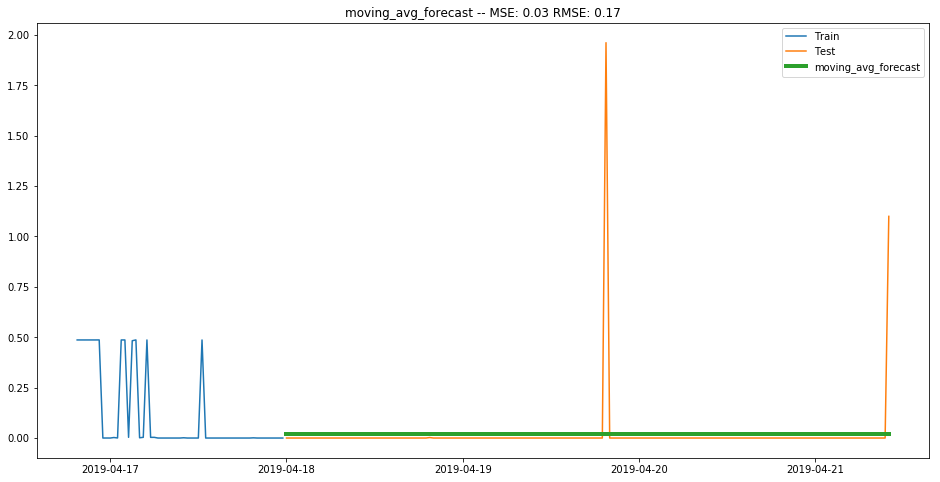

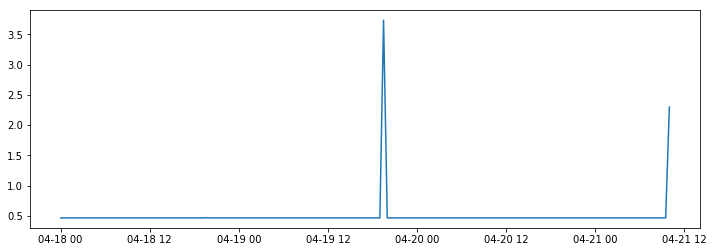

In [61]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)